In [4]:

import networkx as nx
import numpy as np
import grakel as gk
import matplotlib.pyplot as plt


import sys
sys.path.append("../")
import MMDforGraphs as mg
from importlib import reload  
foo = reload(mg)

# Create a class which  generates binomial graphs

In [5]:
# super class with different labelling schemes
class DegreeGraphs():
    """
    Wrapper for graph generator, defines all labelling schemes
    """

    def __init__(self, n, nnode, k, l = None,  a = None, fullyConnected = False, **kwargs) -> None:
        """
        :param kernel: Dictionary with kernel information
        :param n: Number of samples
        :param nnode: Number of nodes
        :param k: Degree
        :param l: Labelling scheme
        :param a: Attribute scheme
        :param **kwargs: Arguments for the labelling functions
        """
        self.n = n
        self.nnode = nnode
        self.k = k
        self.l = l
        self.a = a
        self.kwargs = kwargs
        self.fullyConnected = fullyConnected


    def samelabels(self, G):
        """
        labelling Scheme. All nodes get same label

        :param G: Networkx graph
        """
        return dict( ( (i, 'a') for i in range(len(G)) ) )

    def degreelabels(self, G):
        """
        labelling Scheme. Nodes labelled with their degree

        :param G: Networkx graph
        :return: Dictionary
        """

        nodes_degree = dict(G.degree)
        return {key: str(value) for key, value in nodes_degree.items()}

    def normattr(self, G):
        """
        Node attributes from normal distribution, all with same location and scale

        :param G: Networkx graph
        :return: Dictionary
        """
        loc = self.kwargs.get('loc', 0)
        scale = self.kwargs.get('scale', 1)
        return dict( ( (i, np.random.normal(loc = loc, scale = scale, size = (1,))) for i in range(len(G)) ) )

    def rnglabels(self, G):
        """
        labelling Scheme. Nodes labelled accodring to a discrete pmf

        :param G: Networkx graph
        :param pmf: pmf as list. If None then uniform over all entries
        :return: Dictionary
        """
        import string
        assert not self.kwargs['nr_letters'] is None, "Number of letters (nr_letters) has to be specified"
        assert  np.sum(self.kwargs['pmf']) >0.999, "pmf has to sum to 1"

        # check if the pmf of labels has been given
        if not 'pmf' in self.kwargs.keys():
            pmf = None
        else:
            pmf = self.kwargs['pmf']

        letters = list(string.ascii_lowercase[:self.kwargs['nr_letters']])
        return dict( ( (i, np.random.choice(letters, p = pmf)) for i in range(len(G)) ) )


class BinomialGraphs(DegreeGraphs):
    """
    Class that generates tvo samples of binomial graphs and compares them.
    """
    def __init__(self,  n, nnode, k, l = None,  a = None, **kwargs):
        super().__init__( n, nnode, k, l ,  a, **kwargs )
        self.p = k/float(nnode-1)
        self.k = k

    def Generate(self) -> None:
        """
        :return: list of networkx graphs
        """
        self.Gs = []

        # p = np.zeros(self.n+1)
        # p[0] = self.p
        # latent_process = np.zeros(self.n+1)

        beta = self.kwargs['beta']
        sigma = self.kwargs['sigma']
        latent_process = np.zeros(self.n+1)
        latent_process[0] = np.random.normal(0, sigma)
        p = np.zeros(self.n+1)
        p[0] = 1/(1+ np.exp(beta + latent_process[0]))

        for i in range(self.n):

            if self.kwargs['temporal']:
                #print(k[i])
                p_tmp = p[i]
                #print(p_tmp)
                #p = k[i]/float(self.nnode-1)
                latent_process[i+1] = self.kwargs['auto']*latent_process[i] + np.random.normal(0, sigma)
                p[i+1] = 1/(1+ np.exp(beta + latent_process[i+1]))

            else:
                p_tmp = self.p

            if self.fullyConnected:
                while True:
                    G = nx.fast_gnp_random_graph(self.nnode, p_tmp)
                    if nx.is_connected(G):
                        break
            else:
                G = nx.fast_gnp_random_graph(self.nnode, p_tmp)

            if (not self.l is None) and (not self.a is None):
                label = getattr(self, self.l)
                label_dict = label(G)
                nx.set_node_attributes(G, label_dict, 'label')
                attributes = getattr(self, self.a)
                attribute_dict = attributes(G)
                nx.set_node_attributes(G, attribute_dict, 'attr')
            elif not self.l is None:
                label = getattr(self, self.l)
                label_dict = label(G)
                nx.set_node_attributes(G, label_dict, 'label')
            elif not self.a is None:
                attributes = getattr(self, self.a)
                attribute_dict = attributes(G)
                nx.set_node_attributes(G, attribute_dict, 'attr')
            self.Gs.append(G)

Define functions for wild bootstrapping

In [98]:
def simpleArima(ar, var, nsamples):
    import statsmodels.api as sm
    # x = np.zeros(nsamples)
    # x[0] = np.random.normal(0, np.sqrt(var))
    # for i in range(nsamples-1):
    #     x[i+1] = x[i] * ar + np.random.normal(0, np.sqrt(var))

    # return np.array(x)
    return sm.tsa.arma_generate_sample([1, ar], [var], nsamples)


def WildSeries(ln:float, nsamples):
    ln = float(ln)
    # print(isinstance(ln, float))

    ar = np.exp(-1.0/ln)
    var = 1.0-np.exp(-2.0/ln)

    return simpleArima(ar, var, nsamples)


def WildBootstrap(K, ln, n_x, n_y, B = 1000):
    """
    
    :param ln: Wild bootstran
    :param n_x: number of samples in sample 1
    :param n_y: number of samples in sample 2
    """
    # Wil bootstrap
    K_xx = K[:n_x, :n_x]
    K_yy = K[n_x:, n_x:]
    K_xy = K[:n_x, n_x:]

    #statMatrix = K_xx + K_yy - 2 * K_xy
    statistic_sample = np.mean(K_xx) + np.mean(K_yy) - 2.0*np.mean(K_xy)
    #statistic_sample = 1.0 / (n_x ** 2) * K_xx.sum() + 1.0 / (n_x * n_y) * K_yy.sum() - 2.0 / (n_y ** 2) * K_xy.sum()

    test = np.zeros(B)

    for b in range(B):
        w_x = WildSeries(ln, n_x)
        w_y = WildSeries(ln, n_y)
        # WW = np.outer( np.concatenate((w_x, w_y)), np.concatenate((w_x, w_y)))
        WW = np.block([[np.outer(w_x, w_x), np.outer(w_y, w_x)], [np.outer(w_x, w_y), np.outer(w_y, w_y)]])
        K_p = np.multiply(K, WW)
        test[b] =  np.mean(K_p[:n_x, :n_x]) + np.mean(K_p[n_x:, n_x:]) - 2.0*np.mean(K_p[:n_x, n_x:])

        #test[b] = (1.0/n_x ** 2)  *(np.dot(w_x.T,K_xx).dot(w_x)) + (1.0/n_y** 2) *(np.dot(w_y.T,K_yy).dot(w_y)) - (2.0/(n_x*n_y)) *(np.dot(w_x.T,K_xy).dot(w_y))

    return (test > statistic_sample).sum()/B, test,statistic_sample, K_p


from sklearn.metrics.pairwise import pairwise_kernels

# find best hyperparameter, heuristic
def PairwiseDistance(d1, d2):
    distances = np.array([1.0] * (len(d1)*len(d2)))
    cnt = 0 # dummy to append to distances
    for i in range(len(d1)):
        # not sure if should take i = j
        # not sure if I should take i ~ j and j ~ i
        for j in range(len(d2)):
            # print(str(i) + str(j) + "ok \n")
            distances[cnt] = np.linalg.norm(d1[i]-d2[j])
            cnt += 1
            # print(data_1[i])
            # print(data_2[j])

    # print(distances)
    return np.median(distances)

In [99]:
n = 300
nr_samples = 10

mmd_b = np.zeros(nr_samples)
mmd_b_p = np.zeros(nr_samples)

for i in range(nr_samples):


    p_x = simpleArima(0.5, 1.0 ** 2, n)
    p_y = simpleArima(0.5, 1.0 ** 2, n)

    # d = PairwiseDistance(p_x,p_y)
    K = pairwise_kernels(np.reshape(np.concatenate((p_x,p_y)), (2*n,1)), np.reshape(np.concatenate((p_x,p_y)), (2*n,1)), metric='rbf', gamma = 0.5) # 1/(2*d**2))

    # boot_class = mg.BoostrapMethods(list_of_functions= [mg.MMD_b, mg.MMD_u])
    # boot_class.Bootstrap(K = K, function_arguments=[dict(n = n, m = n ), dict(n = n, m = n )], B = 1000)    
    # #print(f' Normal bootstrap {boot_class.p_values}') 
    # mmd_b[i] = boot_class.p_values['MMD_b']

    # Wild bootstrap
    mmd_b_p[i], test,statistic_sample, K_p = WildBootstrap(K, 20, n, n)
    print(f' Wild bootstrap: {mmd_b_p[i]}, iteration {i}')

#print(f' Normal bootstrap: {np.sum(mmd_b < 0.05)}')
print(f' Wild bootstrap rejections: {np.sum(mmd_b_p < 0.05)}')

 Wild bootstrap: 0.003, iteration 0


KeyboardInterrupt: 

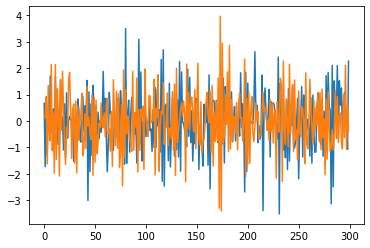

In [93]:
plt.plot(range(len(p_x)), p_x)
plt.plot(range(len(p_y)), p_y)

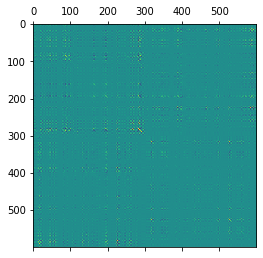

In [86]:
plt.matshow(K_p)

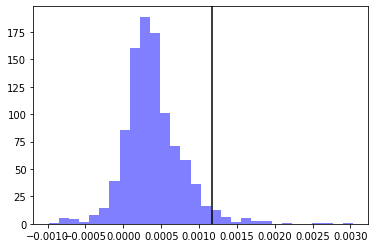

In [87]:
n, bins, patches = plt.hist(test, 30, facecolor='blue', alpha=0.5)
plt.axvline(statistic_sample, color = 'black')
plt.show()

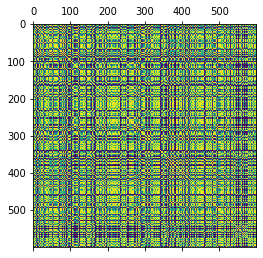

In [88]:
plt.matshow(K)

# Graph test
Do some simulations. If auto1 != auto2 then the graph bootstraps fails to reject. 

In [140]:
#np.random.seed(12312)
# nr bootstrap
B = 100
nr_simulations = 1

mmd_b = np.zeros(nr_simulations)
mmd_b_p = np.zeros(nr_simulations)


auto1 = 0.2 # AR part for the latent process
beta1 = 2 
sigma1 = 0.1  # standar deviation of latent process noise

auto2 = 0.2 # AR part for the latent process
beta2 = 2 
sigma2 = 0.1  # standar deviation of latent process noise

for i in range(nr_simulations):
    # Generate graphs. The nodes are labeled with their degree
    g1 = BinomialGraphs(n = 100, nnode = 40, k = 4, l = 'degreelabels', temporal = True, auto = auto1, beta = beta1, sigma = sigma1) 
    g1.Generate()
    g2 = BinomialGraphs(n = 100, nnode = 40, k = 4, l = 'degreelabels', temporal = True, auto = auto2, beta = beta2, sigma = sigma2)
    g2.Generate()

    # generate a list of graphs for the grakel package
    graph_list = gk.graph_from_networkx(g1.Gs + g2.Gs, node_labels_tag='label') #g1.Gs is a list of graphs

    # kernel selection

    # kernel = [{"name": "weisfeiler_lehman", "n_iter": 2}, {"name": "vertex_histogram"}]
    # kernel = [{"name": "propagation", "t_max": 4, "w":0.1, "M":'TV'}]
    # kernel = [{"name": "vertex_histogram"}]
    kernel = [{"name": "pyramid_match", "with_labels":False, "d":8, "L":8}] # ignoring labels
    init_kernel = gk.GraphKernel(kernel= kernel, normalize=True)

    K = init_kernel.fit_transform(graph_list)

    # Homemade bootstrap class
    boot_class = mg.BoostrapMethods(list_of_functions= [mg.MMD_b, mg.MMD_u])
    boot_class.Bootstrap(K = K, function_arguments=[dict(n = g1.n, m = g2.n ), dict(n = g1.n, m = g2.n )], B = 1000)    
    print(f' Normal bootstrap {boot_class.p_values}')

    mmd_b[i] = boot_class.p_values['MMD_b']


    # Wild bootstrap
    mmd_b_p[i], test,statistic_sample, K_p = WildBootstrap(K, 10, g1.n, g2.n)
    print(f' Wild bootstrap: {mmd_b_p[i]}')

print(f' Normal bootstrap: {np.sum(mmd_b < 0.05)}')
print(f' Wild bootstrap: {np.sum(mmd_b_p < 0.05)}')




 Normal bootstrap {'MMD_b': 0.174, 'MMD_u': 0.174}
 Wild bootstrap: 0.0
 Normal bootstrap: 0
 Wild bootstrap: 1


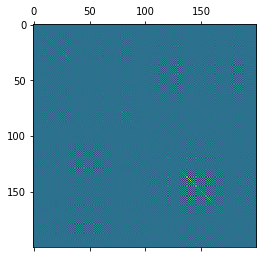

In [141]:
plt.matshow(K_p)

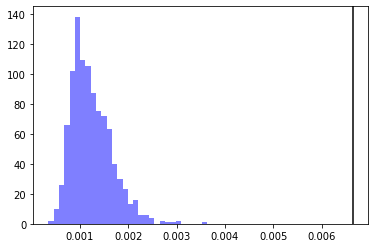

In [142]:
n, bins, patches = plt.hist(test, 30, facecolor='blue', alpha=0.5)
plt.axvline(statistic_sample, color = 'black')
plt.show()

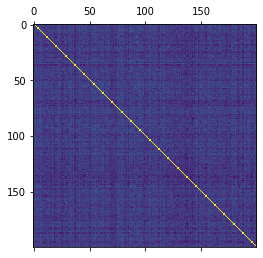

In [143]:
plt.matshow(K)

# Let's perform bootstrapping on the probability process

No handles with labels found to put in legend.


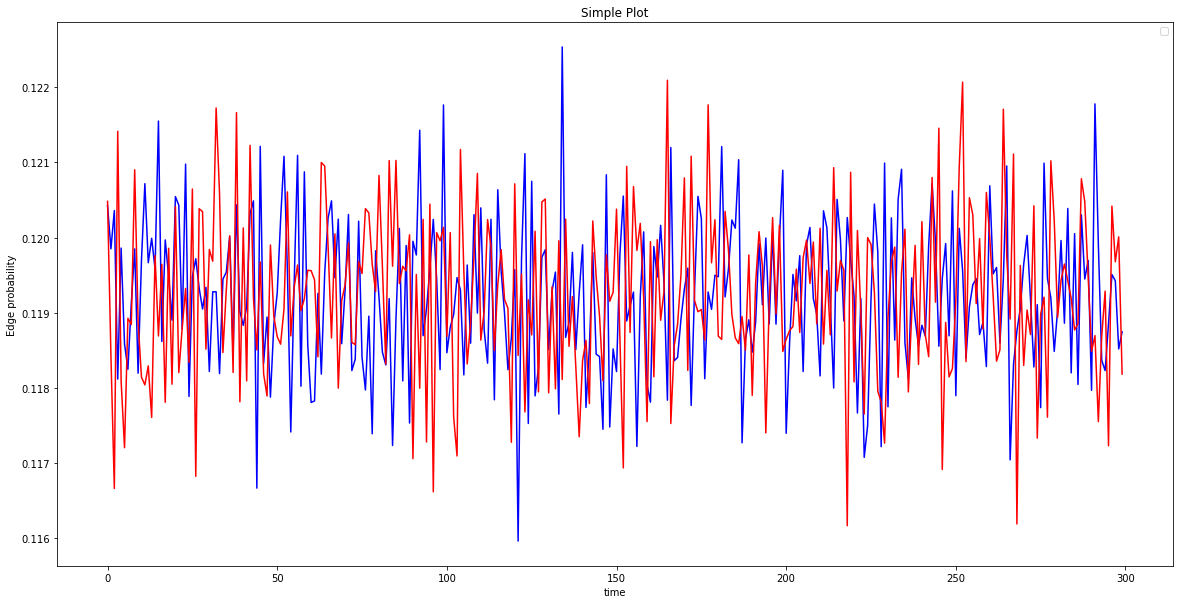

In [132]:

# generate p according to latent process
def ok(n, sigma, beta, auto):
    latent_process = simpleArima(auto, sigma ** 2, n)
    return 1/(1+ np.exp(beta + latent_process))

n = 300
p_x = ok(n, sigma1, beta1, auto1)
p_y = ok(n, sigma2, beta2, auto2)

fig, ax = plt.subplots(figsize=(20, 10))  

ax.plot([x for x in range(n)], p_x, color = 'blue')
ax.plot([x for x in range(n)], p_y, color = 'red')

ax.set_xlabel('time')
ax.set_ylabel('Edge probability')
ax.set_title("Simple Plot")
ax.legend()

In [102]:


# nr paths
n = 100
nr_simulations = 50
mmd_b = np.zeros(nr_simulations)
mmd_b_p = np.zeros(nr_simulations)

for i in range(nr_simulations):

    p_x = ok(n, sigma1, beta1, auto1)
    p_y = ok(n, sigma2, beta2, auto2)

    d = PairwiseDistance(p_x,p_y)
    
    #print(d)

    K = pairwise_kernels(np.reshape(np.concatenate((p_x,p_y)), (2*n,1)), np.reshape(np.concatenate((p_x,p_y)), (2*n,1)), metric='rbf', gamma = 1/(2*d**2))

    boot_class = mg.BoostrapMethods(list_of_functions= [mg.MMD_b, mg.MMD_u])
    boot_class.Bootstrap(K = K, function_arguments=[dict(n = g1.n, m = g2.n ), dict(n = g1.n, m = g2.n )], B = 1000)    
    print(f' Normal bootstrap {boot_class.p_values}')   

    mmd_b[i] = boot_class.p_values['MMD_b']



    # Wild bootstrap
    mmd_b_p[i], test,statistic_sample, K_p = WildBootstrap(K, 10, n, n)
    print(f' Wild bootstrap: {mmd_b_p[i]}')


print(f' Normal bootstrap: {np.sum(mmd_b < 0.05)}')
print(f' Wild bootstrap: {np.sum(mmd_b_p < 0.05)}')

 Normal bootstrap {'MMD_b': 0.986, 'MMD_u': 0.986}
 Wild bootstrap: 0.725
 Normal bootstrap {'MMD_b': 0.596, 'MMD_u': 0.596}
 Wild bootstrap: 0.02
 Normal bootstrap {'MMD_b': 0.064, 'MMD_u': 0.064}
 Wild bootstrap: 0.0
 Normal bootstrap {'MMD_b': 0.24, 'MMD_u': 0.24}
 Wild bootstrap: 0.003
 Normal bootstrap {'MMD_b': 0.081, 'MMD_u': 0.081}
 Wild bootstrap: 0.0
 Normal bootstrap {'MMD_b': 0.514, 'MMD_u': 0.514}
 Wild bootstrap: 0.002
 Normal bootstrap {'MMD_b': 0.541, 'MMD_u': 0.541}
 Wild bootstrap: 0.001
 Normal bootstrap {'MMD_b': 0.134, 'MMD_u': 0.134}
 Wild bootstrap: 0.0
 Normal bootstrap {'MMD_b': 0.59, 'MMD_u': 0.59}
 Wild bootstrap: 0.041
 Normal bootstrap {'MMD_b': 0.876, 'MMD_u': 0.876}
 Wild bootstrap: 0.213
 Normal bootstrap {'MMD_b': 0.224, 'MMD_u': 0.224}
 Wild bootstrap: 0.0
 Normal bootstrap {'MMD_b': 0.055, 'MMD_u': 0.055}
 Wild bootstrap: 0.0
 Normal bootstrap {'MMD_b': 0.383, 'MMD_u': 0.383}
 Wild bootstrap: 0.002
 Normal bootstrap {'MMD_b': 0.87, 'MMD_u': 0.87}
 Wil

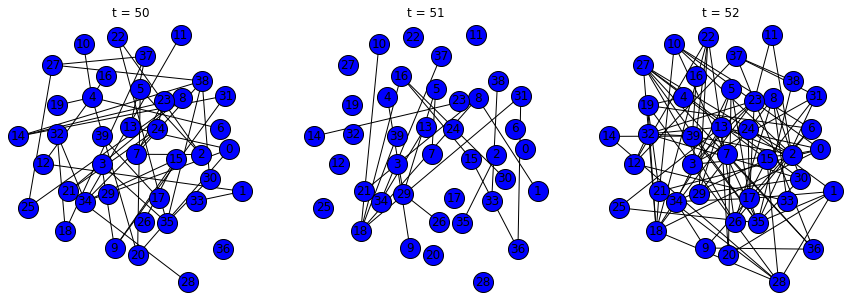

In [17]:

plt.figure(figsize=(15, 5))
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
pos = nx.kamada_kawai_layout(g1.Gs[0])
for j,i in enumerate(range(50,53)):
    plt.subplot(1, 3, j+1)
    color = []
    # for node in g1.Gs[i].nodes:
    #     color.append(c_colors[g1.Gs[i].nodes[node]['label']])
    nx.draw_networkx(g1.Gs[i], pos=pos, node_color='blue', edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title(f't = {i}')